# Moving Violations - Automated Cameras

### Date: May 29, 2021

### Author: Aisling Casey

This notebook explores the composition of traffic tickets in Washington DC from 2018-2020. They are largely automated tickets, captured by speed & red light cameras. 

The first half of the notebook is spent joining the automated camera location data with the traffic violations; whether or not a violation is captured by a camera is not noted in the source data, so it must be gleamed from linking the fine location to the  automated camera location data & violation type. Additionaly, the source automated camera data only specifies exisiting cameras (as of May 2021); cameras that have been take down are not given. So, they are gleamed from a data source on previous & planned cameras from 2014, along with the ticket counts and violations by location. 

After the data is joined, data visualization on ticket composition overtime, tickets at top camera locations over time and data maps are given.

In the future. can probably just segment automated tickets if they meet the following criteria (it took many hours to get to this conclusion :-)   

1.issuing_agency_name is "SPECIAL OPERATION DIV & TRAFFIC DIV" 

2.violation_process_desc is in this list: 

    speed 11-15 mph over the speed limit
    speed 21-25 mph over the speed limit
    speed 16-20 mph over the speed limit
    speed 26-30 mph over the speed limit
    over 25 mph in excess of limit on non-controlled a
    over 25 mph in excess of limit on controlled acces
    turn right on red without complete stop
    fail to stop per regulations facing red signal
    right turn on red, violation no turn on red sign
    passing stop sign without coming to a full stop
    fail to clear intersection
    truck restricted route
    speed up to ten mph over the speed limit
    fail to keep in lane
    turn right on red when prohibited

# Navigation
* [1. Load and Explore Data](#1.LoadandExploreData)
* [2. Join Tickets with Cameras](#2.JoinTicketswithCameras)
* [3.  Identifying Missing Automated Tickets](#3.IdentifyingMissingAutomatedTickets)
* [4. Plots](#4.Plots)
* [5. Mapping](#5.Mapping)

## 1. Load and Explore Data <a class="anchor" id="1.LoadandExploreData"></a>

In [2]:
##Import Libraries
import psycopg2
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import pandas.io.sql as psql
import geopandas as gpd
from collections import Counter
from dateutil.parser import parse
from fuzzywuzzy import fuzz
import SQL_cred
#Note: SQL cred must be created with the SQL credentials given to you by Charlotte, the database manager, to load data from
#the database into this notebook. It should be a .py file with the following format:
#PGHOST=##
#PGDATABASE=##
#PGUSER=##
#port=##
#PGPASSWORD=##

C:\Users\amcas\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
pd.set_option('display.max_rows', 10000) 
pd.set_option('display.max_columns', None)

In [3]:
#Set SQL Address, Create SQL import function 'load_data'
conn_string = "host="+ SQL_cred.PGHOST +" port="+ "5432" +" dbname="+ SQL_cred.PGDATABASE +" user=" + SQL_cred.PGUSER \
+" password="+ SQL_cred.PGPASSWORD

def load_data(query):

    sql_command = query
    print (sql_command)

    # Load the data
    data = pd.read_sql(sql_command, conn)

    print(data.shape)
    return (data)

In [4]:
#Select moving violation information from from 2018 through 2020
conn=psycopg2.connect(conn_string)
query="SELECT objectid, anc_id, ward_name, location, xcoord, ycoord, latitude, longitude, issuing_agency_name, violation_process_desc, dcfunctionalclass_desc, geography, violation_code, issue_date, total_paid, fine_amount \
FROM analysis_data.moving_violations \
WHERE EXTRACT (year FROM issue_date) BETWEEN 2018 AND 2020;"
cursor = conn.cursor()
df_fines=load_data(query)
#df_fines.to_csv('Fines2018to2020.csv')

SELECT objectid, anc_id, ward_name, location, xcoord, ycoord, latitude, longitude, issuing_agency_name, violation_process_desc, dcfunctionalclass_desc, geography, violation_code, issue_date, total_paid, fine_amount FROM analysis_data.moving_violations WHERE EXTRACT (year FROM issue_date) BETWEEN 2018 AND 2020;
(3655393, 16)


In [5]:
#df_fines.to_csv('Fines2018to2020.csv')

In [6]:
#Read in fines data frame, print out info
#df_fines=pd.read_csv('Fines2018to2020.csv',index_col=0)
#Uppercase all locations so that they will match the camera df
df_fines['location']=df_fines['location'].str.upper()
#Drop columns not currently needed
df_fines_intermediate=df_fines.drop(columns=['xcoord','ycoord','anc_id','geography','dcfunctionalclass_desc','violation_code',])

In [29]:
#Get moving violations from months missing, as of May 7 2021 - July 2018 and February 2019
#Combine into df: df_fines_final
df_fines_072018=pd.read_csv('MissingMovingViolations/Moving_Violations_Issued_in_July_2018.csv',parse_dates=['ISSUE_DATE'], date_parser=parse)
df_fines_022019=pd.read_csv('MissingMovingViolations/Moving_Violations_Issued_in_February_2019.csv',parse_dates=['ISSUE_DATE'], date_parser=parse)
df_fines_072018=df_fines_072018[['OBJECTID','LOCATION','XCOORD', 'YCOORD','ISSUING_AGENCY_NAME', 'VIOLATION_PROCESS_DESC', 'ISSUE_DATE', 'TOTAL_PAID', 'FINE_AMOUNT']]
df_fines_022019=df_fines_022019[['OBJECTID','LOCATION','XCOORD', 'YCOORD', 'ISSUING_AGENCY_NAME','VIOLATION_PROCESS_DESC', 'ISSUE_DATE', 'TOTAL_PAID', 'FINE_AMOUNT']]
df_fines_missing=pd.concat([df_fines_072018,df_fines_022019],axis=0)
df_fines_missing['LOCATION']=df_fines_missing['LOCATION'].str.upper()
colnames=['objectid','location','latitude','longitude','issuing_agency_name','violation_process_desc','issue_date','total_paid','fine_amount']
df_fines_missing=pd.DataFrame(df_fines_missing.values,columns=colnames)
df_fines_final=pd.concat([df_fines_intermediate,df_fines_missing])
df_fines_final['location'].fillna(value='UNKNOWN',inplace=True)
df_fines_final.head()

,objectid,ward_name,location,latitude,longitude,issuing_agency_name,violation_process_desc,issue_date,total_paid,fine_amount
0,11447742,Ward 4,N CAPITOL ST S/B @ GALLATIN ST NW,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-09-14 04:00:00+00:00,0.0,150.0
1,11577440,Ward 4,N CAPITOL ST S/B @ GALLATIN ST NW,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-20 04:00:00+00:00,0.0,150.0
2,11577474,Ward 4,N CAPITOL ST S/B @ GALLATIN ST NW,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0
3,11577477,Ward 4,N CAPITOL ST S/B @ GALLATIN ST NW,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0
4,11577680,Ward 4,N CAPITOL ST S/B @ GALLATIN ST NW,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0


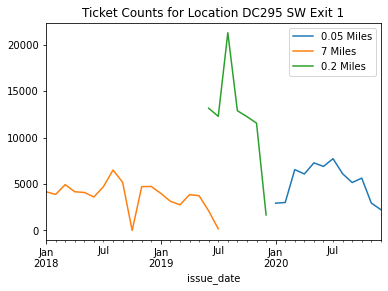

In [34]:
#Something weird going on with these locations
interim_df=df_fines_final.copy()

interim_df.issue_date=pd.to_datetime(interim_df.issue_date,format="%Y/%m/%d",utc=True)

s=interim_df[interim_df.location=='DC295 SW .05 MILE S/O EXIT 1 N/B'].set_index('issue_date')
s.resample('M').objectid.count().plot(label='0.05 Miles')

y=interim_df[interim_df.location=='DC295 SW .7 MILES S/O EXIT 1 S/B'].set_index('issue_date')
y.resample('M').objectid.count().plot(label='7 Miles')

f=interim_df[interim_df.location=='DC295 SW .2 MILES S/O E/1 N/B (WZ)'].set_index('issue_date')
f.resample('M').objectid.count().plot(label='0.2 Miles')

plt.title('Ticket Counts for Location DC295 SW Exit 1')
plt.legend()
plt.show()

In [35]:
#Change a misspelled address; has same lat/long as the rectified address name. Its the N/B Exit off of 295 in SW
df_fines_final.loc[df_fines_final.location=='DC295 SW .2 MILES S/O E/1 N/B (WZ)', 'location']='DC295 SW .05 MILE S/O EXIT 1 N/B'

In [36]:
#Read in camera data frame, print out info
df_cameras=pd.read_csv('Aux_Data/Camera_Enforcement_Locations.csv')
df_cameras.sort_values('OBJECTID')

,X,Y,OBJECTID,ID,ENFORCEMENT,ADDRESS,DISTRICT,WARD,ANC,PSA,SPEED,XCOORD,YCOORD,LOCATIONCODE,VENDOR,MAR_ADDRESS,MAR_ID
20,-77.027893,38.930650,1,1,STOP SIGN SAFETY CAMERA,11th St n/b @ Lamont St NW,3,1,1A,302,NaN,397573.070012,140312.980000,8308,Sensys,LAMONT STREET NW AND 11TH STREET NW,907333
21,-77.055651,38.935637,2,1,SPEED SAFETY CAMERA,2500 blk Porter St NW w/b,2,3,3C,203,25.0,395175.220000,140861.920000,8209,Sensys,PORTER STREET NW FROM WILLIAMSBURG LANE NW TO ...,813039
22,-77.036417,38.952543,3,4,SPEED SAFETY CAMERA,16th St s/b @ Colorado Ave NW,4,4,4A/4C,403/404,25.0,396843.557723,142737.743010,8402,Sensys,16TH STREET NW AND COLORADO AVENUE NW,903866
23,-77.078571,38.912697,4,23,SPEED SAFETY CAMERA,4300 blk Reservoir Rd NW e/b,2,2,2E,206,25.0,393185.800000,138316.900000,9295,VM,RESERVOIR ROAD NW FROM 39TH STREET NW TO 44TH ...,812695
24,-77.073130,38.924167,5,24,SPEED SAFETY CAMERA,2600 blk Wisconsin Ave NW n/b,2,3,3B/3C,204,25.0,393653.450000,139589.560000,9296,Sensys,WISCONSIN AVENUE NW FROM DAVIS STREET NW TO ED...,801693
25,-77.092240,38.913901,6,28,SPEED SAFETY CAMERA,4700 blk MacArthur Blvd NW s/b,3,3,3D,205,25.0,392000.500000,138451.670000,9305,VM,MACARTHUR BOULEVARD NW FROM 47TH PLACE NW TO R...,807090
26,-77.013895,38.931294,7,34,SPEED SAFETY CAMERA,100 blk Irving St NW w/b,4,5,5A/5E,405,25.0,398793.710000,140371.820000,9418,Sensys,IRVING STREET NW FROM 1ST STREET NW TO KENYON...,807403
27,-77.006075,38.934487,8,36,SPEED SAFETY CAMERA,3000 blk N Capitol St NW sw,4,5,5A,405,25.0,399473.490000,140732.860000,9494,VM,NORTH CAPITOL STREET FROM MICHIGAN AVENUE NW T...,811116
28,-76.981271,38.872420,9,73,SPEED SAFETY CAMERA,DC 295 .4 mi s/o Penn Ave SE sw/b,7,8,8A,607,50.0,401625.483000,133844.553000,9708,VM,NaN,NaN
29,-76.970839,38.941207,10,8,SPEED SAFETY CAMERA,4200 blk Eastern Ave NE se/b,6,5,5B,503,25.0,402524.710000,141458.420000,8535,Sensys,EASTERN AVENUE NE FROM RUSSELL AVENUE NE TO KA...,800881


In [37]:
#Modifications to Camera data frame
#Supply ward name & ANC id for one speed camera that is missing this information (ObjectID 121, Corner of Rhode Island & North Capital NE)
a=list(df_cameras.loc[df_cameras.OBJECTID==121].index.values)
df_cameras.WARD.fillna('5',inplace=True)
df_cameras.ANC.fillna('5E',inplace=True)
#Uppercase all locations so that they will match the fines df
df_cameras['ADDRESS']=df_cameras['ADDRESS'].str.upper()
#Add 'Type' Column
type={'SPEED SAFETY CAMERA':'SPEED','RED LIGHT SAFETY CAMERA':'RED LIGHT OR STOP','STOP SIGN SAFETY CAMERA':'RED LIGHT OR STOP','OVERSIZED SAFETY CAMERA':'TRUCK'}
df_cameras['CAMERA_TYPE']=df_cameras.ENFORCEMENT.map(type)
#Drop duplocate/currently not needed columns from both cameras df
df_cameras_=df_cameras.drop(columns=['ID','DISTRICT','PSA','XCOORD','YCOORD','LOCATIONCODE','MAR_ADDRESS','MAR_ID'])
#Rename object id of camera to camera id
df_cameras_.rename(columns={'OBJECTID':'CAMERA_ID'},inplace=True)

In [38]:
r=pd.DataFrame(df_cameras_.ENFORCEMENT.value_counts()).reset_index()
r.rename(columns={'index':'Camera Type','ENFORCEMENT':'Count'},inplace=True)
r

,Camera Type,Count
0,SPEED SAFETY CAMERA,78
1,RED LIGHT SAFETY CAMERA,40
2,STOP SIGN SAFETY CAMERA,7
3,OVERSIZED SAFETY CAMERA,2


In [39]:
#Merge camera and fines dataframe, create df_automatic_merged that has a rows for each violation caught by a camera
df_automatic_merged=pd.merge(df_cameras_,df_fines_final,left_on='ADDRESS',right_on='location',suffixes=['_cam','_fine'])
dict_names={'X':'X_CAMERA','Y':'Y_CAMERA','latitude':'lat_fine','longitude':'long_fine'}
df_automatic_merged.rename(columns=dict_names,inplace=True)
df_automatic_merged.drop(columns='location',inplace=True)
df_automatic_merged['num_tickets']=1
df_automatic_merged.head(5)

,X_CAMERA,Y_CAMERA,CAMERA_ID,ENFORCEMENT,ADDRESS,WARD,ANC,SPEED,VENDOR,CAMERA_TYPE,objectid,ward_name,lat_fine,long_fine,issuing_agency_name,violation_process_desc,issue_date,total_paid,fine_amount,num_tickets
0,-76.977984,38.937441,109,SPEED SAFETY CAMERA,3900 BLK SOUTH DAKOTA AVE NE SE/B,5,5B,25.0,VM,SPEED,10000137,Ward 5,38.938,-76.978,SPECIAL OPERATION DIV & TRAFFIC DIV,SPEED 11-15 MPH OVER THE SPEED LIMIT,2020-06-29 04:00:00+00:00,0.0,100.0,1
1,-76.977984,38.937441,109,SPEED SAFETY CAMERA,3900 BLK SOUTH DAKOTA AVE NE SE/B,5,5B,25.0,VM,SPEED,10000159,Ward 5,38.938,-76.978,SPECIAL OPERATION DIV & TRAFFIC DIV,SPEED 11-15 MPH OVER THE SPEED LIMIT,2020-06-29 04:00:00+00:00,0.0,100.0,1
2,-76.977984,38.937441,109,SPEED SAFETY CAMERA,3900 BLK SOUTH DAKOTA AVE NE SE/B,5,5B,25.0,VM,SPEED,10000198,Ward 5,38.938,-76.978,SPECIAL OPERATION DIV & TRAFFIC DIV,SPEED 11-15 MPH OVER THE SPEED LIMIT,2020-06-29 04:00:00+00:00,100.0,100.0,1
3,-76.977984,38.937441,109,SPEED SAFETY CAMERA,3900 BLK SOUTH DAKOTA AVE NE SE/B,5,5B,25.0,VM,SPEED,10000221,Ward 5,38.938,-76.978,SPECIAL OPERATION DIV & TRAFFIC DIV,SPEED 21-25 MPH OVER THE SPEED LIMIT,2020-06-29 04:00:00+00:00,0.0,200.0,1
4,-76.977984,38.937441,109,SPEED SAFETY CAMERA,3900 BLK SOUTH DAKOTA AVE NE SE/B,5,5B,25.0,VM,SPEED,10000315,Ward 5,38.938,-76.978,SPECIAL OPERATION DIV & TRAFFIC DIV,SPEED 11-15 MPH OVER THE SPEED LIMIT,2020-06-29 04:00:00+00:00,0.0,100.0,1


In [40]:
 print(len(np.sort(df_automatic_merged.CAMERA_ID.unique()))), print(np.sort(df_automatic_merged.CAMERA_ID.unique()))

109
[  1   4   5   6   7   9  10  11  12  13  14  15  16  18  19  22  24  25
  26  27  28  29  30  32  33  34  35  36  37  38  39  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  69  70  71  72  73  74  75  76  78  80  81  82  84  85
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 109 110 112 113 114 115 116 117 118 119 120 121 123 124 125
 127]


(None, None)

In [41]:
#Cameras that aren't linking up with any records
id_inlist=list(df_automatic_merged.CAMERA_ID.unique())
camera_no_link=df_cameras_[~df_cameras_.CAMERA_ID.isin(id_inlist)].sort_values('CAMERA_ID')
cam_no_address=list(camera_no_link.ADDRESS)
camera_no_link

,X,Y,CAMERA_ID,ENFORCEMENT,ADDRESS,WARD,ANC,SPEED,VENDOR,CAMERA_TYPE
21,-77.055651,38.935637,2,SPEED SAFETY CAMERA,2500 BLK PORTER ST NW W/B,3,3C,25.0,Sensys,SPEED
22,-77.036417,38.952543,3,SPEED SAFETY CAMERA,16TH ST S/B @ COLORADO AVE NW,4,4A/4C,25.0,Sensys,SPEED
27,-77.006075,38.934487,8,SPEED SAFETY CAMERA,3000 BLK N CAPITOL ST NW SW,5,5A,25.0,VM,SPEED
36,-77.042961,38.945089,17,STOP SIGN SAFETY CAMERA,BLAGDEN AVE @ ALLISON ST NW NE/B,4,4A,NaN,Sensys,RED LIGHT OR STOP
39,-77.049980,38.902534,20,SPEED SAFETY CAMERA,2200 BLK K ST NW E/B,2,2A,25.0,VM,SPEED
40,-77.109860,38.933477,21,SPEED SAFETY CAMERA,5700 BLK MACARTHUR BLVD NW N/B,3,3D,25.0,VM,SPEED
42,-76.942197,38.876735,23,SPEED SAFETY CAMERA,699-800 BLK RIDGE RD SE NW/B,7,7E,25.0,VM,SPEED
50,-76.983604,38.909711,31,SPEED SAFETY CAMERA,1200 BLK MT OLIVET RD NE NW/B,5,5C/5D,25.0,Sensys,SPEED
59,-77.041627,38.946224,40,SPEED SAFETY CAMERA,4600 BLK BLAGNEN AVE NW SW/B,4,4A,25.0,VM,SPEED
87,-76.959313,38.924140,68,SPEED SAFETY CAMERA,3200 BLK FORT LINCOLN DR NE S/B,5,5C,25.0,VM,SPEED


In [42]:
#Link the closest location from the fines df according to fuzzywuzzy score
unique_locations=list(df_fines_final.location.unique())
closest_match=[]
score=[]
for str_ in cam_no_address:
    q=[]
    for i in unique_locations:
        q.append(fuzz.WRatio(i,str_))
    max_value=max(q)
    b=q.index(max_value)
    closest_match.append(unique_locations[b])
    score.append(max_value)
    print(str_,' ',closest_match[-1], 'Score: {}'.format(max_value))

2500 BLK PORTER ST NW W/B    2500 BLK PORTER ST NW W/B Score: 100
16TH ST S/B @ COLORADO AVE NW    16TH ST S/B @ COLORADO AVE NW Score: 100
3000 BLK N CAPITOL ST NW SW   3000 BLK N CAPITOL ST NW S/B Score: 95
BLAGDEN AVE @ ALLISON ST NW NE/B   BLAGDEN AVE NE/B @ ALLISON ST NW Score: 95
2200 BLK K ST NW E/B   2200 BLK K ST NW W/B Score: 95
5700 BLK MACARTHUR BLVD  NW N/B   5700 BLK MACARTHUR BLVDA NW N/B Score: 98
699-800 BLK RIDGE RD SE NW/B   800 BLK RIDGE RD  SE NW/B Score: 95
1200 BLK MT OLIVET RD NE NW/B    1200 BLK MT OLIVET RD NE NW/B Score: 100
4600 BLK BLAGNEN AVE NW SW/B   4600 BLK BLAGDEN AVE NW SW/B Score: 96
3200 BLK FORT LINCOLN DR NE S/B   3200 BLK FORT LINCOLN DRIVE NE S/B Score: 95
2500 BLK MARTIN LUTHER KING AVE SE N/B   2500 BLK MARTIN LUTHER KING AVE SE Score: 95
1900 BLK SOUTHERN AVE NE NE/B   1900 BLK SOUTHERN AVE SE NE/B Score: 97
5700 BLK MACARTHUR BLVD  NW S/B   5700 BLK MACARTHUR BLVDA NW S/B Score: 98
GALLATIN ST W/B @ 6TH PL NE    GALLATIN ST W/B @ 6TH PL NE 

In [43]:
#This code shows that '2200 BLK K ST NW E/B' is being incorrectly matched with '2200 BLOCK K ST NW W/B'
#Link the closest location from the fines df according to fuzzywuzzy score
unique_locations=list(df_fines_final.location.unique())
fuzz_scores={}
q=[]
for i in unique_locations:
    fuzz_scores[i]=fuzz.WRatio(i,'2200 BLK K ST NW E/B')
pd.DataFrame.from_dict(fuzz_scores,orient='index',columns=['score']).sort_values('score',ascending=False).head(100)

,score
2200 BLK K ST NW W/B,95
2200 BLOCK K ST NW E/B,95
K ST NW,90
N CAPITOL ST S/B @ GALLATIN ST NW,86
UNIT INDPENDENCE AND 1ST ST SW,86
18TH/I ST NW,86
RAMP FROM PA AVE TO W/B 395 SE,86
1900 9TH ST,86
4/K ST NW,86
UNIT P ST SW,86


In [44]:
#Create a dataframe, cam_no_address, with the matching addresses & their scores
columns=['camera_address','violation_address','score']
df_match=pd.DataFrame({'camera_address':cam_no_address,'violation_address':closest_match,'score':score})
#Need to swtich out '2200 BLK K ST NW W/B' for E/B
df_match.loc[df_match['violation_address']=='2200 BLK K ST NW W/B','violation_address']='2200 BLOCK K ST NW E/B'
df_match

,camera_address,violation_address,score
0,2500 BLK PORTER ST NW W/B,2500 BLK PORTER ST NW W/B,100
1,16TH ST S/B @ COLORADO AVE NW,16TH ST S/B @ COLORADO AVE NW,100
2,3000 BLK N CAPITOL ST NW SW,3000 BLK N CAPITOL ST NW S/B,95
3,BLAGDEN AVE @ ALLISON ST NW NE/B,BLAGDEN AVE NE/B @ ALLISON ST NW,95
4,2200 BLK K ST NW E/B,2200 BLOCK K ST NW E/B,95
5,5700 BLK MACARTHUR BLVD NW N/B,5700 BLK MACARTHUR BLVDA NW N/B,98
6,699-800 BLK RIDGE RD SE NW/B,800 BLK RIDGE RD SE NW/B,95
7,1200 BLK MT OLIVET RD NE NW/B,1200 BLK MT OLIVET RD NE NW/B,100
8,4600 BLK BLAGNEN AVE NW SW/B,4600 BLK BLAGDEN AVE NW SW/B,96
9,3200 BLK FORT LINCOLN DR NE S/B,3200 BLK FORT LINCOLN DRIVE NE S/B,95


In [45]:
#Switch out the proper addresses in df_cameras, filling in na of violation address with ADDRESS, df_cameras_ original address column
df_cameras_=df_cameras_.merge(df_match.drop(columns='score'),how='left',left_on='ADDRESS',right_on='camera_address')
df_cameras_.violation_address.fillna(df_cameras_['ADDRESS'],inplace=True)
df_cameras_.drop(columns=['ADDRESS','camera_address'],inplace=True)
df_cameras_.rename(columns={'violation_address':'ADDRESS'},inplace=True)

In [47]:
#Make a dictionary to categorize the automatic violation types
#unique_violations=list(df_automatic_merged['violation_process_desc'].value_counts(sort=False).index)
#dict_={}
#for i in unique_violations:
#    txt=input(i+' ')
#    dict_[i]=txt
#dict_

In [48]:
dict_={'FAIL TO CLEAR INTERSECTION': 'RED LIGHT OR STOP',
 'SPEED UP TO TEN MPH OVER THE SPEED LIMIT': 'SPEED',
 'TURN RIGHT ON RED WHEN PROHIBITED': 'RED LIGHT OR STOP',
 'FAIL TO STOP PER REGULATIONS FACING RED SIGNAL': 'RED LIGHT OR STOP',
 'SPEED 26-30 MPH OVER THE SPEED LIMIT': 'SPEED',
 'SPEED 21-25 MPH OVER THE SPEED LIMIT': 'SPEED',
 'FAIL TO KEEP IN LANE': 'RED LIGHT OR STOP',
 'SPEED 16-20 MPH OVER THE SPEED LIMIT': 'SPEED',
 'OVER 25 MPH IN EXCESS OF LIMIT ON NON-CONTROLLED A': 'SPEED',
 'TURN RIGHT ON RED WITHOUT COMPLETE STOP': 'RED LIGHT OR STOP',
 'TRUCK RESTRICTED ROUTE': 'TRUCK',
 'SPEED 11-15 MPH OVER THE SPEED LIMIT': 'SPEED',
 'OVER 25 MPH IN EXCESS OF LIMIT ON CONTROLLED ACCES': 'SPEED',
 'RIGHT TURN ON RED, VIOLATION NO TURN ON RED SIGN': 'RED LIGHT OR STOP',
 'PASSING STOP SIGN WITHOUT COMING TO A FULL STOP': 'RED LIGHT OR STOP'}

In [49]:
#Create Violation Type column in df_fines_final 
df_fines_final['VIOLATION_TYPE']=df_fines_final.violation_process_desc.map(dict_)

## 2. Join Tickets with Cameras <a class="anchor" id="2.JoinTicketswithCameras"></a>

In [50]:
#Do speed camera join, keep all non speed camera violations using right
df_all_merged=pd.merge(df_cameras_,df_fines_final,how='right',left_on=['ADDRESS','CAMERA_TYPE'],right_on=['location','VIOLATION_TYPE'],suffixes=['_cam','_fine'])
dict_names={'X':'X_CAMERA','Y':'Y_CAMERA','latitude':'lat_fine','longitude':'long_fine'}
df_all_merged.rename(columns=dict_names,inplace=True)
df_all_merged.drop(columns='location',inplace=True)
df_all_merged['num_tickets']=1
len(df_fines_final)==len(df_all_merged)

True

In [51]:
df_all_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3885664 entries, 0 to 3885663
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   X_CAMERA                3118049 non-null  float64
 1   Y_CAMERA                3118049 non-null  float64
 2   CAMERA_ID               3118049 non-null  float64
 3   ENFORCEMENT             3118049 non-null  object 
 4   WARD                    3118049 non-null  object 
 5   ANC                     3118049 non-null  object 
 6   SPEED                   2550244 non-null  float64
 7   VENDOR                  3104966 non-null  object 
 8   CAMERA_TYPE             3118049 non-null  object 
 9   ADDRESS                 3118049 non-null  object 
 10  objectid                3885664 non-null  object 
 11  ward_name               3522431 non-null  object 
 12  lat_fine                3729390 non-null  object 
 13  long_fine               3729390 non-null  object 
 14  is

In [52]:
#Get the addresses & ward of non automatic fines added (location column), drop ADDRESS column
q=df_fines_final[['location','objectid']]
df_all_merged=pd.merge(df_all_merged,q,left_on=['objectid'],right_on=['objectid'])
df_all_merged.location.fillna(value='ADDRESS',inplace=True)
df_all_merged.drop(columns='ADDRESS',inplace=True)

In [53]:
#Cameras seem to pick up their proper violation types
df_all_merged[['ENFORCEMENT','violation_process_desc']].value_counts(sort=False)

ENFORCEMENT              violation_process_desc                            
OVERSIZED SAFETY CAMERA  TRUCK RESTRICTED ROUTE                                    550
RED LIGHT SAFETY CAMERA  FAIL TO CLEAR INTERSECTION                                 13
                         FAIL TO KEEP IN LANE                                        4
                         FAIL TO STOP PER REGULATIONS FACING RED SIGNAL         135225
                         RIGHT TURN ON RED, VIOLATION NO TURN ON RED SIGN         1322
                         TURN RIGHT ON RED WHEN PROHIBITED                           1
                         TURN RIGHT ON RED WITHOUT COMPLETE STOP                 57532
SPEED SAFETY CAMERA      OVER 25 MPH IN EXCESS OF LIMIT ON CONTROLLED ACCES       7417
                         OVER 25 MPH IN EXCESS OF LIMIT ON NON-CONTROLLED A       7191
                         SPEED 11-15 MPH OVER THE SPEED LIMIT                  2289114
                         SPEED 16-20 MPH OVER THE SPEE

In [54]:
print(len(np.sort(df_all_merged.CAMERA_ID.unique()))), print(np.sort(df_all_merged.CAMERA_ID.unique()))

128
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127.  nan]


(None, None)

In [55]:
#Ensure there are no duplicate violations (object id)
list_cams=df_all_merged[df_all_merged.duplicated(subset='objectid',keep=False)].CAMERA_ID.value_counts().index
list_cams=[int(i) for i in list_cams]
df_cameras[df_cameras.OBJECTID.isin(list_cams)]

,X,Y,OBJECTID,ID,ENFORCEMENT,ADDRESS,DISTRICT,WARD,ANC,PSA,SPEED,XCOORD,YCOORD,LOCATIONCODE,VENDOR,MAR_ADDRESS,MAR_ID,CAMERA_TYPE


In [56]:
#Fill non automatic camera types with "Not Camera Enforced"
df_all_merged.CAMERA_TYPE.fillna(value='NOT CAMERA ENFORCED',inplace=True)
df_all_merged.CAMERA_TYPE.value_counts(dropna=False)

SPEED                  2812147
NOT CAMERA ENFORCED     767615
RED LIGHT OR STOP       305352
TRUCK                      550
Name: CAMERA_TYPE, dtype: int64

## 3.  Identifying Missing Automated Tickets <a class="anchor" id="3.IdentifyingMissingAutomatedTickets"></a>

In [57]:
#What are the most common violations among the "non" automatic tickets? 
df_notauto_types=pd.DataFrame(df_all_merged[df_all_merged.CAMERA_TYPE=='NOT CAMERA ENFORCED'].violation_process_desc.value_counts()).reset_index()
df_notauto_types.rename(columns={'index':'Type','violation_process_desc':'Count'},inplace=True)
top=df_notauto_types[df_notauto_types.Count>10000].Count.sum()
total=df_notauto_types.Count.sum()
pct=round(top/total*100,2)
a=df_notauto_types[df_notauto_types.Count>10000].Type[0]
b=df_notauto_types[df_notauto_types.Count>10000].Type[1]
print("The two violation types that account for {} of 'non automatic' tickets are {} and {}".format(pct,a,b))

The two violation types that account for 82.51 of 'non automatic' tickets are SPEED 11-15 MPH OVER THE SPEED LIMIT and SPEED 16-20 MPH OVER THE SPEED LIMIT


In [58]:
#Get a list of all 'Not camera enforced' locations with more than 100 tickets
t=pd.DataFrame(df_all_merged[df_all_merged.CAMERA_TYPE=='NOT CAMERA ENFORCED'].groupby('location').num_tickets.count()).reset_index()
loc_more_100=list(t[t.num_tickets>100].location)

#Get a list of all automated ticked types 
df_violation_types_camera=list(df_all_merged[df_all_merged.CAMERA_TYPE!='NOT CAMERA ENFORCED'].violation_process_desc.unique())

#Isolate tickets that meet criteria likely to be automated tickets: df_suspected_non_auto
cond_a=df_all_merged.violation_process_desc.isin(df_violation_types_camera)
cond_b=df_all_merged.CAMERA_TYPE=='NOT CAMERA ENFORCED'
cond_c=df_all_merged.issuing_agency_name=='SPECIAL OPERATION DIV & TRAFFIC DIV'
df_suspected_non_auto=df_all_merged[(cond_a) & (cond_b) & (cond_c)]
#Only include locations with more than 100 tickets
t=pd.DataFrame(df_suspected_non_auto.groupby('location').num_tickets.count()).reset_index()
df_suspected_non_auto=df_suspected_non_auto[df_suspected_non_auto.location.isin(list(t[t.num_tickets>100].location))]
#Create a list of suspected locations
list_suspected_non_auto_location=list(df_suspected_non_auto.location.value_counts().index)

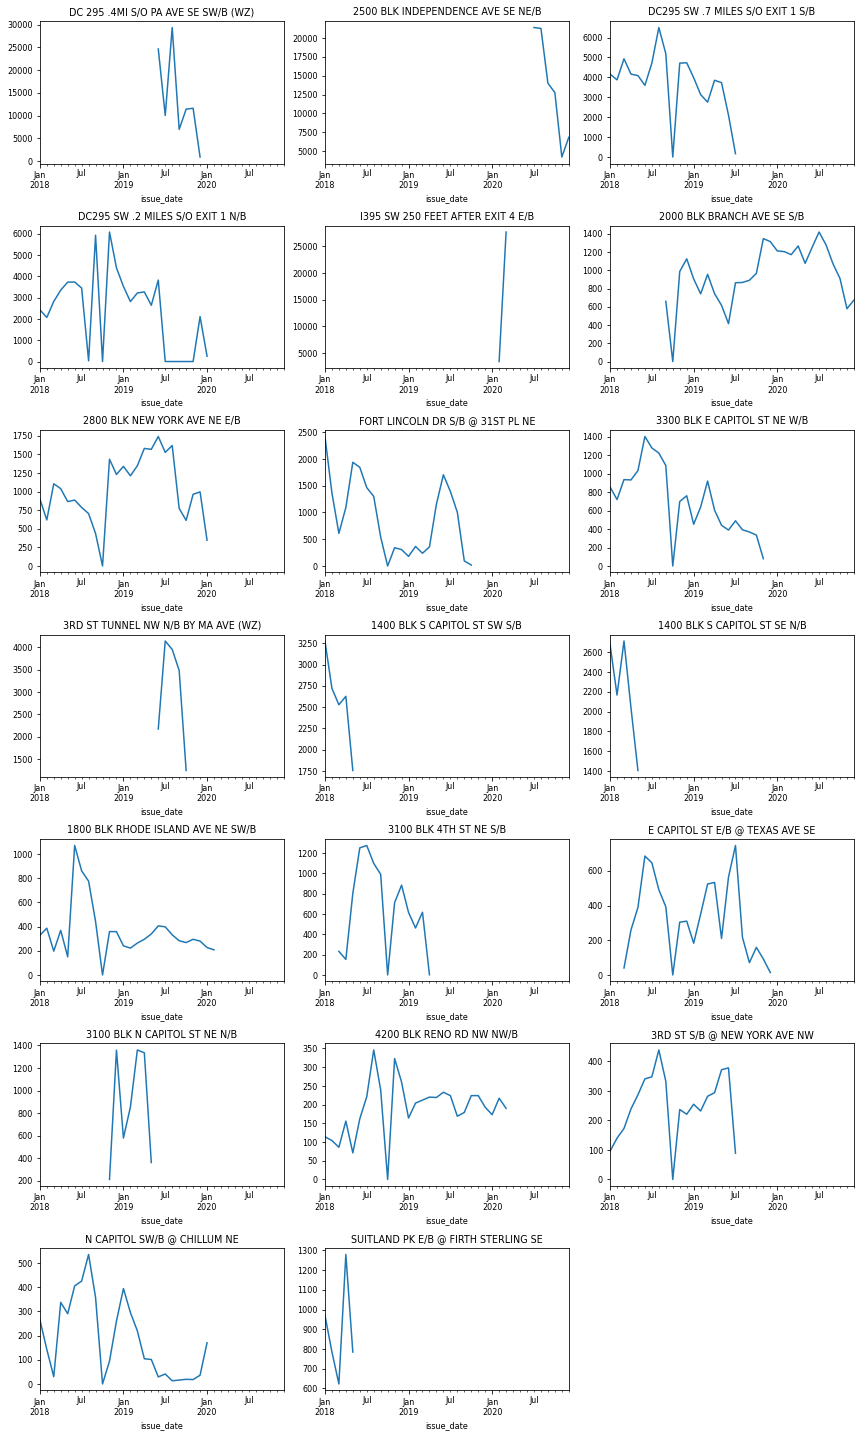

In [59]:
#Change the issue date to a datetime object
df_suspected_non_auto.issue_date=pd.to_datetime(df_suspected_non_auto.issue_date,format="%Y/%m/%d",utc=True)

#Plot the Monthly tickets for most active, 'non automatic' locations
k=1
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(12,20))
for i in [i for i in list_suspected_non_auto_location[0:20]]:
    plt.subplot(7,3,k)
    q=df_suspected_non_auto[df_suspected_non_auto.location==i]
    q.set_index('issue_date')['num_tickets'].resample('M').sum().plot()
    k=k+1
    plt.title(q.location.unique()[0])
    plt.xlim(['2018-01','2020-12'])
plt.tight_layout()
plt.show()

#Some of these plots are clearly speed cameras - only 'active' for a few months, and issuing thousands of tickets

In [60]:
#Import List of existing & proposed cameras from Nexus Study 2014
#This list comes from this document: http://ddotfiles.com/SpeedCameras/Safety_Nexus_Executive_Summary.pdf
#It includes a list of existing, planned & proposed speed cameras as of 2014. 
df_prop_cam=pd.read_csv('Aux_Data/Proposed_Speed_Cameras_Nexus_2014.csv')
df_prop_cam.Location=df_prop_cam.Location.str.upper()
df_prop_cam.head()

,Location#,District,PSA,Ward,ANC,Phase,Location
0,2,4,409,1,1A,Existing,OREGON BLK PARK PL NW S/B
1,3,3,304/305,1,1B,Existing,100 BLK FLORIDA AVE NW NW/B
2,1,4,408,1,1A/1D,Planned,16TH ST S/B @ IRVING ST
3,131,3,302,1,1A,Proposed,"400 BLK WARDER STREET, NW E/B"
4,132,5,302,1,1A,Proposed,1500 BLK. MONROE ST. NE (EB)


In [61]:
#Link the closest location of the camera list from the fines df according to fuzzywuzzy score
closest_match2=[]
score2=[]
for str_ in list_suspected_non_auto_location:
    q=[]
    for i in list(df_prop_cam.Location):
        q.append(fuzz.WRatio(i,str_))
    max_value=max(q)
    b=q.index(max_value)
    closest_match2.append(list(df_prop_cam.Location)[b])
    score2.append(max_value)

In [62]:
#Create a dataframe, cam_no_address, with the matching addresses & their scores
columns=['violation_address','proposed_cam_address','score']
df_match_missing_auto=pd.DataFrame({'violation_address':list_suspected_non_auto_location,'camera_address':closest_match2,'score':score2})
df_match_missing_auto.sort_values('score',ascending=False)
#Add number of tickets column by joining df_all_merged grouped by location 
r=pd.DataFrame(df_suspected_non_auto.groupby('location').num_tickets.sum()).reset_index()
df_match_missing_auto=pd.merge(df_match_missing_auto,r,left_on='violation_address',right_on='location')
df_match_missing_auto.drop(columns='location',inplace=True)
#Add most common violation type at each site
df_sus_violation_types=df_suspected_non_auto.groupby(['location','violation_process_desc'])['num_tickets'].count().reset_index().sort_values(by=['location','num_tickets'],ascending=False)
g=pd.DataFrame(df_sus_violation_types.groupby('location').violation_process_desc.first()).reset_index().rename(columns={'violation_process_desc':'Most_Common_Ticket'})
df_match_missing_auto=pd.merge(df_match_missing_auto,g,left_on='violation_address',right_on='location')
df_match_missing_auto.drop(columns='location',inplace=True)
#Add Camera Type Column
df_match_missing_auto['Camera_Type']=df_match_missing_auto.Most_Common_Ticket.apply(lambda x: 'SPEED' if 'SPEED' in x else 'RED LIGHT OR STOP' )
##Join Camera Phase Column
df_match_missing_auto=pd.merge(df_match_missing_auto,df_prop_cam[['Phase','Location']],how='left',left_on='camera_address',right_on='Location')
df_match_missing_auto.drop(columns='Location',inplace=True)

In [63]:
#Keep locations that only meet the following critera/combination of criteria
cond_a=df_match_missing_auto.num_tickets>1000
cond_b=df_match_missing_auto.score>=92
cond_c=(df_match_missing_auto.Phase=='Existing')|(df_match_missing_auto.Phase=='Planned')
df_match_missing_auto=df_match_missing_auto[(cond_a) | ((cond_b) & (cond_c))].sort_values(by='num_tickets',ascending=False).reset_index().drop(columns='index')

In [64]:
df_match_missing_auto[df_match_missing_auto.duplicated(subset='violation_address',keep=False)]
#For some reason, this address is duplicated? Will delete

,violation_address,camera_address,score,num_tickets,Most_Common_Ticket,Camera_Type,Phase
28,DC295 NE .1MILE S/O EASTERN AVE S/B,DC295 NE .1MILE S/O EASTERN AVE,95,2527,SPEED 11-15 MPH OVER THE SPEED LIMIT,SPEED,Existing
29,DC295 NE .1MILE S/O EASTERN AVE S/B,DC295 NE .1MILE S/O EASTERN AVE,95,2527,SPEED 11-15 MPH OVER THE SPEED LIMIT,SPEED,Existing


In [65]:
df_match_missing_auto.drop_duplicates(subset='violation_address',keep='first',inplace=True)
df_match_missing_auto[df_match_missing_auto.duplicated(subset='violation_address',keep=False)]

,violation_address,camera_address,score,num_tickets,Most_Common_Ticket,Camera_Type,Phase


In [66]:
df_missing_cameras=df_match_missing_auto[['violation_address','Camera_Type']].rename(columns={'violation_address':'ADDRESS','Camera_Type':'CAMERA_TYPE'}).reset_index().drop(columns='index')
q=range(0,len(df_missing_cameras))
q=[i+200 for i in q]
q=pd.Series(q,name='CAMERA_ID')
df_missing_cameras=pd.concat([df_missing_cameras,q],axis=1)
df_missing_cameras

,ADDRESS,CAMERA_TYPE,CAMERA_ID
0,DC 295 .4MI S/O PA AVE SE SW/B (WZ),SPEED,200
1,2500 BLK INDEPENDENCE AVE SE NE/B,SPEED,201
2,DC295 SW .7 MILES S/O EXIT 1 S/B,SPEED,202
3,DC295 SW .2 MILES S/O EXIT 1 N/B,SPEED,203
4,I395 SW 250 FEET AFTER EXIT 4 E/B,SPEED,204
5,2000 BLK BRANCH AVE SE S/B,SPEED,205
6,2800 BLK NEW YORK AVE NE E/B,SPEED,206
7,FORT LINCOLN DR S/B @ 31ST PL NE,RED LIGHT OR STOP,207
8,3300 BLK E CAPITOL ST NE W/B,SPEED,208
9,3RD ST TUNNEL NW N/B BY MA AVE (WZ),SPEED,209


In [67]:
#Check missing camera locations against exisiting camera list
#Link the closest location of the exisiting camera list to the missing camera list according to fuzzywuzzy score
closest_match3=[]
score3=[]
missing=list(df_missing_cameras.ADDRESS)
existing=list(df_cameras_.ADDRESS)
for str_ in missing:
    q=[]
    for i in existing:
        q.append(fuzz.WRatio(i,str_))
    max_value=max(q)
    b=q.index(max_value)
    closest_match3.append(existing[b])
    score3.append(max_value)
#Create a dataframe to compare exisiting cameras with missing ones, and their proposed type
existing_list_types=[list(df_cameras_.loc[df_cameras_.ADDRESS==i,'CAMERA_TYPE']) for i in closest_match3]
q=pd.DataFrame({'missing_address':missing,'known_address':closest_match3,'missing_type':df_missing_cameras.CAMERA_TYPE,'known_type':existing_list_types,'score':score3})
q.sort_values('score',ascending=False)
#The 100% matches are different camera types, so they won't overlap when joined
#3RD ST TUNNEL NW N/B BY MA AVE (WZ) is clearly meant to link with the exisitng camera - will need to fix

,missing_address,known_address,missing_type,known_type,score
14,E CAPITOL ST E/B @ TEXAS AVE SE,E CAPITOL ST E/B @ TEXAS AVE SE,SPEED,[RED LIGHT OR STOP],100
29,PENNSYLVANIA AVE SE/B @ 27TH ST SE,PENNSYLVANIA AVE SE/B @ 27TH ST SE,SPEED,[RED LIGHT OR STOP],100
24,NEW YORK AVE SW/B @ N CAPITOL ST NE,NEW YORK AVE SW/B @ N CAPITOL ST NE,SPEED,[RED LIGHT OR STOP],100
22,PENNSYLVANIA AVE W/B @ MINNESOTA SE,PENNSYLVANIA AVE W/B @ MINNESOTA SE,SPEED,[RED LIGHT OR STOP],100
33,S DAKOTA SE/B @ BLADENSBURG RD NE,S DAKOTA SE/B @ BLADENSBURG RD NE,SPEED,[RED LIGHT OR STOP],100
34,BRANCH AVE N/B @ ALABAMA AVE SE,BRANCH AVE N/B @ ALABAMA AVE SE,SPEED,[RED LIGHT OR STOP],100
38,3900 BLK PENNSYLVANIA AVE SE NW/B,3000 BLK PENNSYLVANIA AVE SE NW/B,SPEED,[SPEED],97
28,DC295 NE .1MILE S/O EASTERN AVE S/B,DC295 NE .1MILE S/O EASTERN AVE N/B,SPEED,[SPEED],97
25,3600 BLK ALABAMA AVE SE NE/B,3100 BLK ALABAMA AVE SE NE/B,SPEED,[SPEED],96
36,3RD ST TUNNEL NW S/B BY 3RD ST (WZ),3RD ST TUNNEL NW S/B BY 3RD ST,SPEED,[SPEED],95


In [68]:
df_missing_cameras=df_match_missing_auto[['violation_address','Camera_Type']]
df_missing_cameras.rename(columns={'violation_address':'ADDRESS','Camera_Type':'CAMERA_TYPE'},inplace=True)
q=range(0,len(df_missing_cameras)+1)
q=[i+200 for i in q]
q=pd.Series(q,name='CAMERA_ID')
df_missing_cameras=pd.concat([df_missing_cameras,q],axis=1)
df_cameras_2=pd.concat([df_cameras_,df_missing_cameras]).reset_index()
df_cameras_2.drop(columns=['index'])
df_cameras_2.dropna(subset=['ADDRESS'],inplace=True)

C:\Users\amcas\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [69]:
df_cameras_2[df_cameras_2.duplicated(subset='ADDRESS',keep=False)].sort_values(by='ADDRESS')

,index,X,Y,CAMERA_ID,ENFORCEMENT,WARD,ANC,SPEED,VENDOR,CAMERA_TYPE,ADDRESS
22,22,-77.036417,38.952543,3,SPEED SAFETY CAMERA,4,4A/4C,25.0,Sensys,SPEED,16TH ST S/B @ COLORADO AVE NW
115,115,-77.036417,38.952543,96,RED LIGHT SAFETY CAMERA,4,4A/4C,NaN,VM,RED LIGHT OR STOP,16TH ST S/B @ COLORADO AVE NW
65,65,-76.959002,38.861931,46,RED LIGHT SAFETY CAMERA,7,7B,NaN,VM,RED LIGHT OR STOP,BRANCH AVE N/B @ ALABAMA AVE SE
162,35,NaN,NaN,235,NaN,NaN,NaN,NaN,NaN,SPEED,BRANCH AVE N/B @ ALABAMA AVE SE
48,48,-76.938229,38.889784,29,RED LIGHT SAFETY CAMERA,7,7D/7E/7F,NaN,VM,RED LIGHT OR STOP,E CAPITOL ST E/B @ TEXAS AVE SE
141,14,NaN,NaN,214,NaN,NaN,NaN,NaN,NaN,SPEED,E CAPITOL ST E/B @ TEXAS AVE SE
35,35,-77.033427,38.962050,16,SPEED SAFETY CAMERA,4,4A,25.0,Sensys,SPEED,MILITARY RD W/B @ 14TH ST NW
71,71,-77.033427,38.962050,52,RED LIGHT SAFETY CAMERA,4,4A,NaN,VM,RED LIGHT OR STOP,MILITARY RD W/B @ 14TH ST NW
72,72,-77.008919,38.907406,53,RED LIGHT SAFETY CAMERA,5/6,5E/6C,NaN,VM,RED LIGHT OR STOP,NEW YORK AVE SW/B @ N CAPITOL ST NE
151,24,NaN,NaN,224,NaN,NaN,NaN,NaN,NaN,SPEED,NEW YORK AVE SW/B @ N CAPITOL ST NE


In [70]:
#Make a copy of df fines final
df_fines_final2=df_fines_final.copy()
#Fix 3rd St Tunnel Error 
df_fines_final2.loc[df_fines_final2.location=='3RD ST TUNNEL NW N/B BY MA AVE (WZ)','location']='3RD ST TUNNEL NW N/B BY MA AVE'
#Drop nearly duplicate 3rd St Tunnel Camera from camera list
df_cameras_2=df_cameras_2[df_cameras_2.ADDRESS!='3RD ST TUNNEL NW N/B BY MA AVE (WZ)']

In [71]:
#Do speed camera join, keep all non speed camera violations using right join
df_all_merged=pd.merge(df_cameras_2,df_fines_final2,how='right',left_on=['ADDRESS','CAMERA_TYPE'],right_on=['location','VIOLATION_TYPE'],suffixes=['_cam','_fine'])
dict_names={'X':'X_CAMERA','Y':'Y_CAMERA','latitude':'lat_fine','longitude':'long_fine'}
df_all_merged.rename(columns=dict_names,inplace=True)
df_all_merged.drop(columns='location',inplace=True)
df_all_merged['num_tickets']=1
len(df_fines_final2)==len(df_all_merged)

True

In [72]:
#Get the addresses & ward of non automatic fines added (location column)
q=df_fines_final2[['location','objectid']]
df_all_merged=pd.merge(df_all_merged,q,left_on=['objectid'],right_on=['objectid'])
df_all_merged.location.fillna(value='ADDRESS',inplace=True)
df_all_merged.drop(columns='ADDRESS',inplace=True)
df_all_merged.rename(columns={'location':'ADDRESS'},inplace=True)

In [73]:
#Make sure the number of objectids are the same between final fines and the new table
a=len(df_fines_final[~df_fines_final.objectid.isin(list(df_all_merged.objectid))])
b=len(df_all_merged[~df_all_merged.objectid.isin(list(df_fines_final.objectid))])
c=len(df_fines_final[df_fines_final.duplicated(subset='objectid',keep=False)])
d=len(df_all_merged[df_all_merged.duplicated(subset='objectid',keep=False)])
a, b, c, d

(0, 0, 0, 0)

In [74]:
df_all_merged[df_all_merged.duplicated(subset='objectid',keep=False)]

,index,X_CAMERA,Y_CAMERA,CAMERA_ID,ENFORCEMENT,WARD,ANC,SPEED,VENDOR,CAMERA_TYPE,objectid,ward_name,lat_fine,long_fine,issuing_agency_name,violation_process_desc,issue_date,total_paid,fine_amount,VIOLATION_TYPE,num_tickets,ADDRESS


In [75]:
#Fill non automatic camera types with "Not Camera Enforced"
df_all_merged.CAMERA_TYPE.fillna(value='NOT CAMERA ENFORCED',inplace=True)
df_all_merged.CAMERA_TYPE.value_counts(dropna=False)

SPEED                  3340346
RED LIGHT OR STOP       348313
NOT CAMERA ENFORCED     196455
TRUCK                      550
Name: CAMERA_TYPE, dtype: int64

In [76]:
#Print the value counts of ticket types for automated tickets
df_all_merged[df_all_merged.CAMERA_TYPE!='NOT CAMERA ENFORCED'][['ENFORCEMENT','violation_process_desc']].value_counts(sort=False)

ENFORCEMENT              violation_process_desc                            
OVERSIZED SAFETY CAMERA  TRUCK RESTRICTED ROUTE                                    550
RED LIGHT SAFETY CAMERA  FAIL TO CLEAR INTERSECTION                                 13
                         FAIL TO KEEP IN LANE                                        4
                         FAIL TO STOP PER REGULATIONS FACING RED SIGNAL         135225
                         RIGHT TURN ON RED, VIOLATION NO TURN ON RED SIGN         1322
                         TURN RIGHT ON RED WHEN PROHIBITED                           1
                         TURN RIGHT ON RED WITHOUT COMPLETE STOP                 57532
SPEED SAFETY CAMERA      OVER 25 MPH IN EXCESS OF LIMIT ON CONTROLLED ACCES       7417
                         OVER 25 MPH IN EXCESS OF LIMIT ON NON-CONTROLLED A       7251
                         SPEED 11-15 MPH OVER THE SPEED LIMIT                  2301428
                         SPEED 16-20 MPH OVER THE SPEE

In [77]:
#Print the value counts of ticket types for non-automatic tickets
df_all_merged[df_all_merged.CAMERA_TYPE=='NOT CAMERA ENFORCED']['violation_process_desc'].value_counts()

PASSING STOP SIGN WITHOUT COMING TO A FULL STOP       15413
FAIL TO DISPLAY PROOF OF VEHICLE INSURANCE            14836
OWNER OPERATE OR PERMIT OPERATION OF UNINSRD VEH      12209
FAIL TO STOP PER REGULATIONS FACING RED SIGNAL        10041
SPEED 11-15 MPH OVER THE SPEED LIMIT                   9990
DISOBEY TRAFFIC CONTROL DEVICE                         9867
SPEED 16-20 MPH OVER THE SPEED LIMIT                   6824
DISTRACTED DRIVING USING CELL PHONE, OTHER DEVICE      6688
SEAT BELT REGULATION VIOLATION                         5983
FAIL TO PAY ATTENTION WHILE OPERATING A VEHICLE        5312
FAIL TO EXHIBIT REGISTRATION                           4371
ONE RUNNING LIGHT                                      3671
TURNING LEFT WHERE LEFT TURNS ARE PROHIBITED           3670
UNREGISTERED VEHICLE, MORE THAN 30 DAYS                3392
SPEED 21-25 MPH OVER THE SPEED LIMIT                   3287
FAIL TO KEEP IN LANE                                   3207
FAIL TO EXHIBIT DRIVER'S LICENSE OR PERM

In [78]:
#What missing automated tickets remain?
cond_a=df_all_merged.CAMERA_TYPE=='NOT CAMERA ENFORCED'
cond_b=df_all_merged.violation_process_desc.isin(df_violation_types_camera)
cond_c=df_all_merged.issuing_agency_name=='SPECIAL OPERATION DIV & TRAFFIC DIV'
k=df_all_merged[(cond_a)&(cond_b)&(cond_c)]

## 4. Plots <a class="anchor" id="4.Plots"></a>

In [79]:
df_all_merged.head()

,index,X_CAMERA,Y_CAMERA,CAMERA_ID,ENFORCEMENT,WARD,ANC,SPEED,VENDOR,CAMERA_TYPE,objectid,ward_name,lat_fine,long_fine,issuing_agency_name,violation_process_desc,issue_date,total_paid,fine_amount,VIOLATION_TYPE,num_tickets,ADDRESS
0,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11447742,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-09-14 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW
1,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11577440,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-20 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW
2,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11577474,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW
3,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11577477,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW
4,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11577680,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW


In [80]:
#Make issue date a datetime object
df_all_merged.issue_date=pd.to_datetime(df_all_merged.issue_date,format="%Y/%m/%d",utc=True)
#Create a Dataframe with ticket & fine, counts & sums for each camera
dict_={'total_paid':'sum','fine_amount':'sum','num_tickets':'sum'}
df_agg=df_all_merged.groupby(['issue_date','CAMERA_ID','ADDRESS']).aggregate(dict_)
df_agg.reset_index(inplace=True)
#df_agg_all=pd.merge(df_agg,df_cameras_,left_on='OBJECTID',right_on='OBJECTID')
df_agg_all=df_agg.copy()
df_agg_all.issue_date=pd.to_datetime(df_agg_all.issue_date,format="%Y/%m/%d",utc=True)
df_agg_all.head()

,issue_date,CAMERA_ID,ADDRESS,total_paid,fine_amount,num_tickets
0,2018-01-01 05:00:00+00:00,3.0,16TH ST S/B @ COLORADO AVE NW,3870.0,4050.0,39
1,2018-01-01 05:00:00+00:00,4.0,4300 BLK RESERVOIR RD NW E/B,4850.0,5150.0,49
2,2018-01-01 05:00:00+00:00,8.0,3000 BLK N CAPITOL ST NW S/B,2400.0,2250.0,22
3,2018-01-01 05:00:00+00:00,9.0,DC 295 .4 MI S/O PENN AVE SE SW/B,32480.0,35150.0,308
4,2018-01-01 05:00:00+00:00,10.0,4200 BLK EASTERN AVE NE SE/B,450.0,700.0,6


In [81]:
#Get the 5 cameras with the highest number of tickets
ordered_cameras=df_agg_all.groupby('CAMERA_ID').num_tickets.sum().sort_values(ascending=False).index
top5=ordered_cameras[0:5]
top5=[int(i) for i in top5]

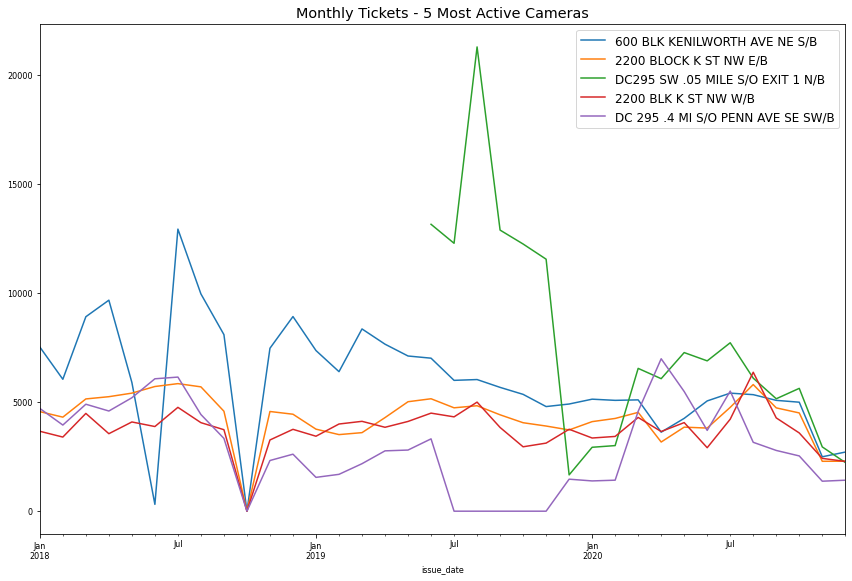

In [82]:
#Plot the Monthly Ticket # from the 5 most active cameras
k=1
for i in top5:
    q=df_agg_all[df_agg_all.CAMERA_ID==i]
    q.set_index('issue_date')['num_tickets'].resample('M').sum().plot(figsize=(12,8),label=q.ADDRESS.unique()[0])
    k=k+1
plt.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.legend()
plt.title('Monthly Tickets - 5 Most Active Cameras' )
plt.show()

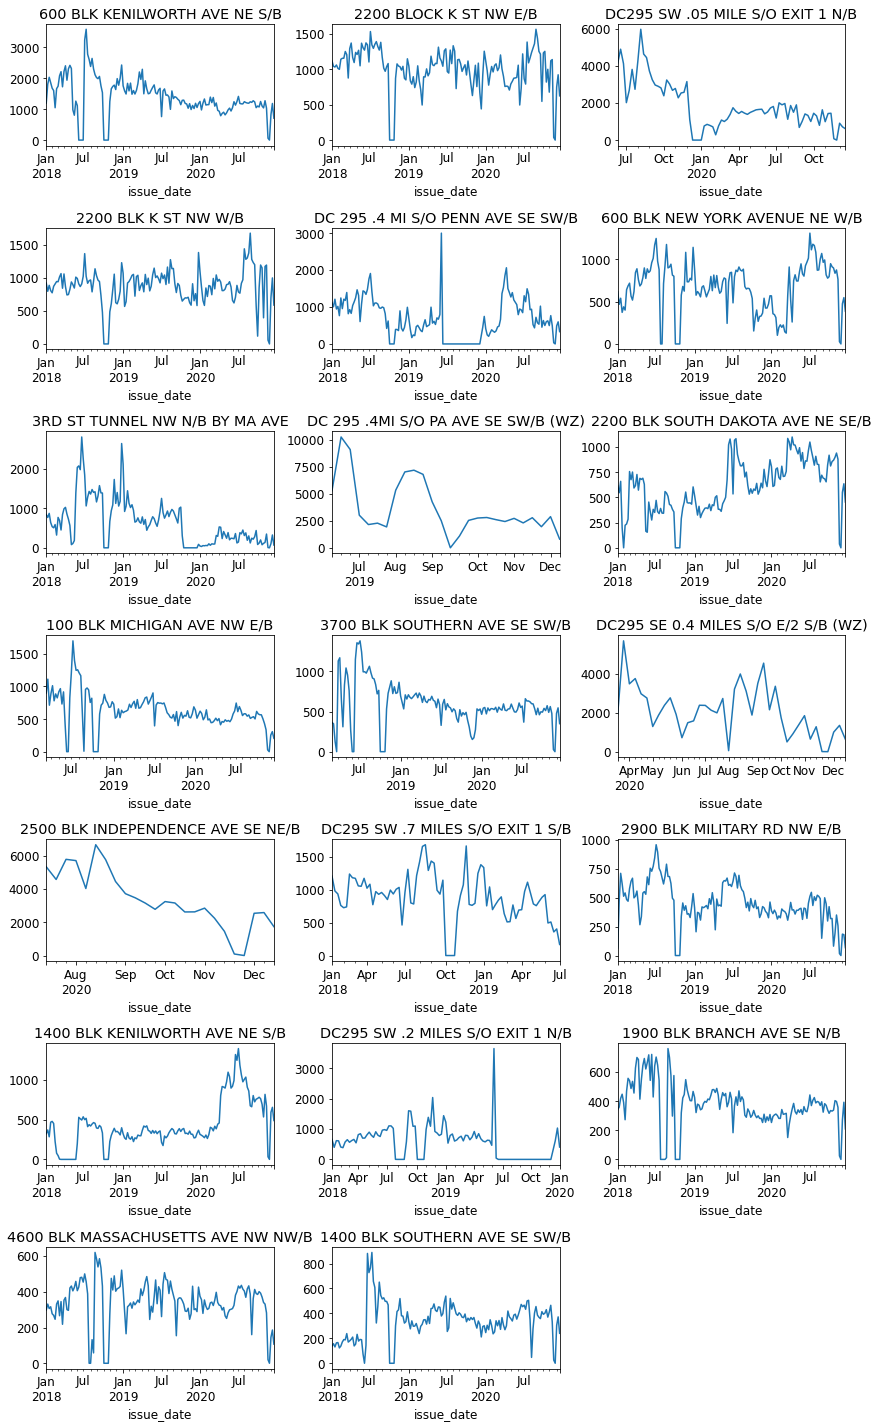

In [83]:
#Plot the weekly tickets given at the 20 most active cameras overtime 
most_tickets42=[int(i) for i in ordered_cameras[0:20]]
k=1
plt.figure(figsize=(12,20))
for i in list(most_tickets42):
    plt.subplot(7,3,k)
    q=df_agg_all[df_agg_all.CAMERA_ID==i]
    q.set_index('issue_date')['num_tickets'].resample('W').sum().plot()
    k=k+1
    plt.title(q.ADDRESS.unique()[0])
plt.tight_layout()
plt.show()

Currently Missing October 2018 Data


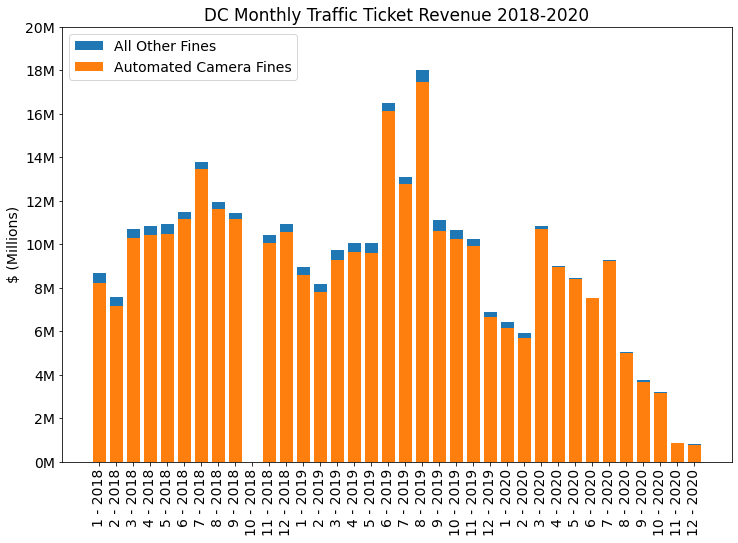

In [84]:
#Plot Ticket revenue by type

#Make date the index of the fines data frame
df_all_merged2=df_all_merged.copy()
df_all_merged2.issue_date=pd.to_datetime(df_all_merged2.issue_date,format="%Y/%m/%d",utc=True)
df_all_merged2.set_index('issue_date',inplace=True)

#Determine monthly fines total; all violations and just cameras
total_fines=df_all_merged2.total_paid.resample('M').sum()
camera_fines=df_all_merged2.dropna(subset=['CAMERA_ID']).total_paid.resample('M').sum()

#Create Graph Labels
steps=[i for i in range(0,22000000,2000000)]
labels=[str(i)+'M' for i in range(0,22,2)]
month=list(camera_fines.index.month)
year=list(camera_fines.index.year)
index=[str(i)+' - '+str(k) for i, k in zip(month,year)]

print('Currently Missing October 2018 Data')

#Plot Bar Graph
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 14})
plt.bar(index,total_fines,bottom=0,label='All Other Fines')
plt.bar(index,camera_fines, label='Automated Camera Fines')
plt.legend(loc='upper left')
plt.yticks(ticks=steps,labels=labels)
plt.xticks(rotation=90)
plt.ylabel('$ (Millions)')
plt.title('DC Monthly Traffic Ticket Revenue 2018-2020')
plt.show()

Currently Missing October 2018 Data


Text(0.5, 1.0, 'DC Monthly Traffic Ticket Count 2018-2020')

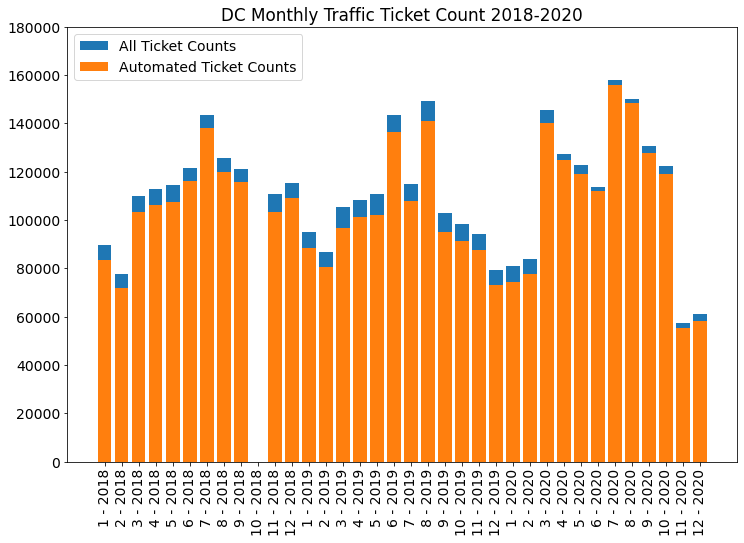

In [85]:
#Plot Ticket count by type

#Make date the index of the fines data frame
df_all_merged2=df_all_merged.copy()
df_all_merged2.issue_date=pd.to_datetime(df_all_merged2.issue_date,format="%Y/%m/%d",utc=True)
df_all_merged2.set_index('issue_date',inplace=True)

#Determine monthly fines total; all violations and just cameras
total_count=df_all_merged2.num_tickets.resample('M').sum()
camera_count=df_all_merged2.dropna(subset=['CAMERA_ID']).num_tickets.resample('M').sum()

#Create Graph Labels
steps=[i for i in range(0,200000,20000)]
#labels=[str(i)+'M' for i in range(0,22,2)]
month=list(camera_count.index.month)
year=list(camera_count.index.year)
index=[str(i)+' - '+str(k) for i, k in zip(month,year)]

print('Currently Missing October 2018 Data')

#Plot Bar Graph
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 14})
plt.bar(index,total_count,bottom=0,label='All Ticket Counts')
plt.bar(index,camera_count, label='Automated Ticket Counts')
plt.legend(loc='upper left')
plt.yticks(ticks=steps)
plt.xticks(rotation=90)
plt.title('DC Monthly Traffic Ticket Count 2018-2020')
#plt.show()

## 5. Mapping <a class="anchor" id="5.Mapping"></a>

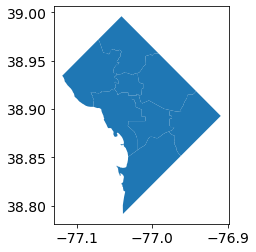

In [86]:
# Read and plot DC Map Geopandas Data Frame
#https://opendata.dc.gov/datasets/0ef47379cbae44e88267c01eaec2ff6e_31?geometry=-77.668%2C38.800%2C-76.361%2C38.987
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
DC=gpd.read_file('DC_Ward_Map/Ward_from_2012.shp')
DC.plot()
plt.show()

<ipython-input-87-e74c77cfee9e>:9: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['NAME'], xy=row['coords'],
No handles with labels found to put in legend.


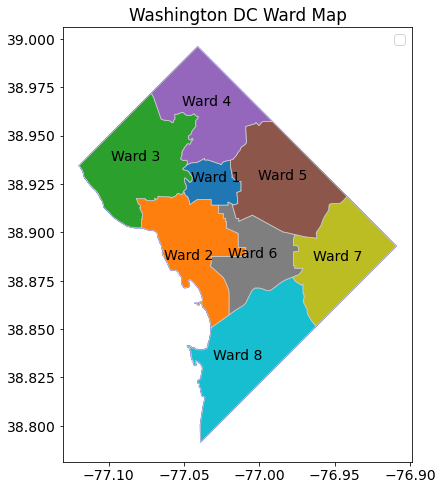

In [87]:
#Add Coords Column to DC geometry for text annotation
DC['coords'] = DC['geometry'].apply(lambda x: x.representative_point().coords[:])
DC['coords'] = [coords[0] for coords in DC['coords']]

#Plot DC Wards with Names
ax=DC.plot(color='white',edgecolor='blue',figsize=(16, 8))
DC.plot(ax=ax,column='NAME', linewidth=0.8, edgecolor='0.8',legend=True)
for idx, row in DC.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],
                 horizontalalignment='center')
plt.title('Washington DC Ward Map')
plt.legend()
plt.show()

In [88]:
#Make geopandas dataframe out of speed camera data
gdf = gpd.GeoDataFrame(df_cameras_, geometry=gpd.points_from_xy(df_cameras_.X, df_cameras_.Y))
gdf.drop(columns=['X','Y','SPEED','VENDOR'],inplace=True)
gdf.head()

,CAMERA_ID,ENFORCEMENT,WARD,ANC,CAMERA_TYPE,ADDRESS,geometry
0,108,SPEED SAFETY CAMERA,5,5E,SPEED,2600 BLK LINCOLN RD NE N/B,POINT (-77.00319 38.92461)
1,109,SPEED SAFETY CAMERA,5,5B,SPEED,3900 BLK SOUTH DAKOTA AVE NE SE/B,POINT (-76.97798 38.93744)
2,110,SPEED SAFETY CAMERA,5,5B,SPEED,3900 BLK SOUTH DAKOTA AVE NE NW/B,POINT (-76.97798 38.93744)
3,111,RED LIGHT SAFETY CAMERA,1/2,1B/2B,RED LIGHT OR STOP,14TH ST S/B @ U ST NW,POINT (-77.03195 38.91701)
4,112,SPEED SAFETY CAMERA,7,7C/7E,SPEED,5500 BLK E CAPITOL ST SE E/B,POINT (-76.92183 38.88976)


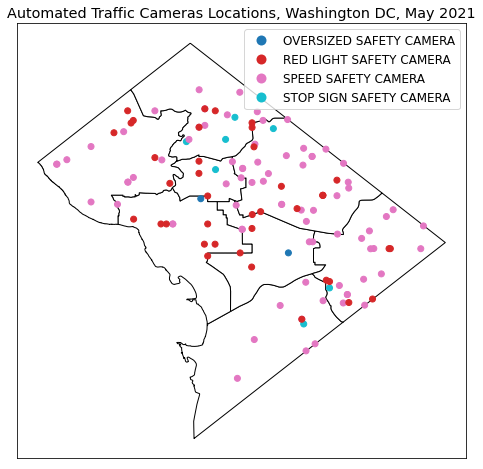

In [89]:
#Plot locations of automated cameras
DC=gpd.read_file('DC_Ward_Map/Ward_from_2012.shp')
plt.rcParams.update({'font.size': 12})
ax=DC.plot(color='white',edgecolor='black',figsize=(12, 8))
gdf.plot(ax=ax, column='ENFORCEMENT',categorical=True,legend=True)
plt.title('Automated Traffic Cameras Locations, Washington DC, May 2021')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [90]:
#Info Pulled From https://www.dchealthmatters.org/demographicdata
dc_ward_pop=pd.DataFrame({'Population':[91673,92809,84979,87150,90380,103197,80669,80517],'ward_name':['Ward 1','Ward 2','Ward 3','Ward 4','Ward 5','Ward 6','Ward 7','Ward 8']})
dc_ward_pop[['ward_name','Population']]

,ward_name,Population
0,Ward 1,91673
1,Ward 2,92809
2,Ward 3,84979
3,Ward 4,87150
4,Ward 5,90380
5,Ward 6,103197
6,Ward 7,80669
7,Ward 8,80517


In [91]:
df_all_merged.head()

,index,X_CAMERA,Y_CAMERA,CAMERA_ID,ENFORCEMENT,WARD,ANC,SPEED,VENDOR,CAMERA_TYPE,objectid,ward_name,lat_fine,long_fine,issuing_agency_name,violation_process_desc,issue_date,total_paid,fine_amount,VIOLATION_TYPE,num_tickets,ADDRESS
0,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11447742,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-09-14 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW
1,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11577440,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-20 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW
2,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11577474,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW
3,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11577477,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW
4,108.0,-77.009009,38.952415,89.0,RED LIGHT SAFETY CAMERA,4/5,4D/5A,NaN,VM,RED LIGHT OR STOP,11577680,Ward 4,38.952,-77.009,SPECIAL OPERATION DIV & TRAFFIC DIV,FAIL TO STOP PER REGULATIONS FACING RED SIGNAL,2020-10-21 04:00:00+00:00,0.0,150.0,RED LIGHT OR STOP,1,N CAPITOL ST S/B @ GALLATIN ST NW


In [92]:
#Fill in missing ward with 'unknown'
df_all_merged.ward_name.fillna(value='Unknown',inplace=True)
#Group automated ticket counts by ward
f=pd.DataFrame(df_all_merged[df_all_merged.CAMERA_TYPE!='NOT CAMERA ENFORCED'].groupby('ward_name').num_tickets.count()).reset_index()
#Group non-automated tickets by ward 
g=pd.DataFrame(df_all_merged[df_all_merged.CAMERA_TYPE=='NOT CAMERA ENFORCED'].groupby('ward_name').num_tickets.count()).reset_index()
h=pd.merge(f,g,left_on='ward_name',right_on='ward_name')
num_tick_by_ward=h.rename(columns={'num_tickets_x':'AutomatedTickets','num_tickets_y':'ManualTickets'})
num_tick_by_ward

,ward_name,AutomatedTickets,ManualTickets
0,Unknown,267094,96139
1,Ward 1,99479,12125
2,Ward 2,339002,22081
3,Ward 3,251831,6504
4,Ward 4,296105,6962
5,Ward 5,689144,14602
6,Ward 6,255208,14885
7,Ward 7,757192,16459
8,Ward 8,734154,6698


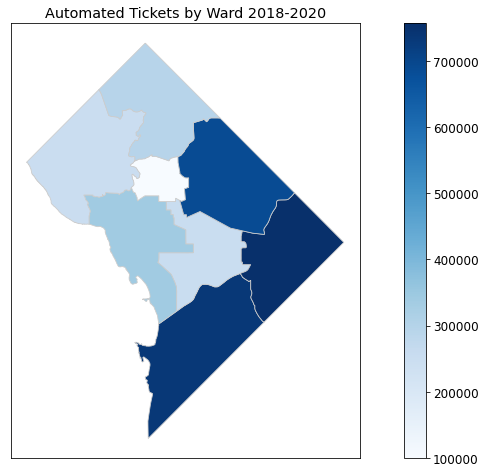

In [93]:
DC_num_tick=pd.merge(DC,num_tick_by_ward,left_on='NAME',right_on='ward_name')
#vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(16, 8))
DC_num_tick.plot(column='AutomatedTickets', cmap="Blues", linewidth=0.8, ax=ax, edgecolor='0.8',legend=True)
plt.title('Automated Tickets by Ward 2018-2020')
plt.rcParams.update({'font.size': 12})
ax.set_xticks([])
ax.set_yticks([])
plt.show()

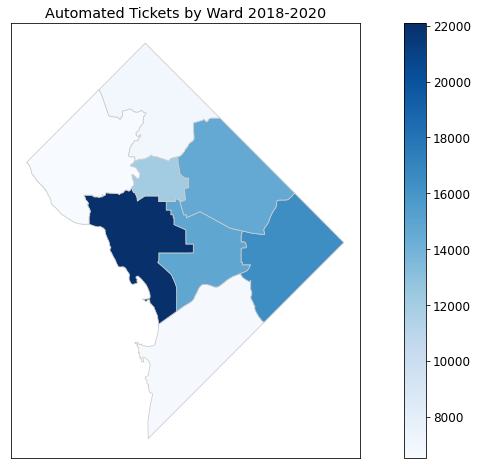

Given how many missing ward locations there are for manual tickets, I don't trust this graph


In [94]:
DC_num_tick=pd.merge(DC,num_tick_by_ward,left_on='NAME',right_on='ward_name')
#vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(16, 8))
DC_num_tick.plot(column='ManualTickets', cmap="Blues", linewidth=0.8, ax=ax, edgecolor='0.8',legend=True)
plt.title('Automated Tickets by Ward 2018-2020')
plt.rcParams.update({'font.size': 12})
ax.set_xticks([])
ax.set_yticks([])
plt.show()

print("Given how many missing ward locations there are for manual tickets, I don't trust this graph")

Break down of all ticket types


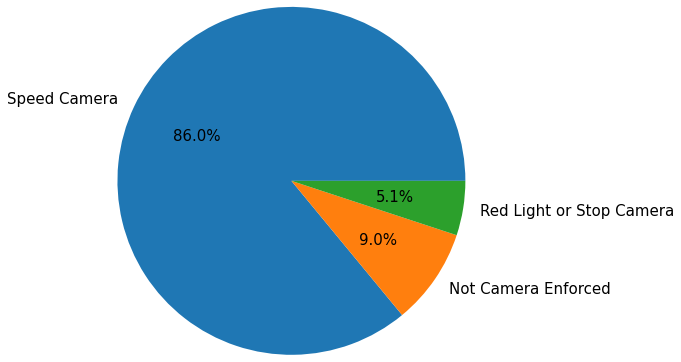

In [95]:
#Pie Chart 2018-2020
print('Break down of all ticket types')
violation_types=pd.DataFrame(df_all_merged.CAMERA_TYPE.value_counts()).reset_index()
violation_types.rename(columns={'index':'Type','CAMERA_TYPE':'Count'},inplace=True)
violation_types.Type=['Speed Camera','Not Camera Enforced','Red Light or Stop Camera','Truck']
violation_types=violation_types[violation_types.Type!='Truck']
plt.rcParams.update({'font.size': 15})
plt.pie(violation_types.Count,autopct='%0.1f%%',labels=violation_types.Type,radius=2)
plt.show()

In [96]:
speed_query=df_all_merged.copy()
speed_dict={'OVER 25 MPH IN EXCESS OF LIMIT ON NON-CONTROLLED A':'SPEED 26-30 MPH OVER THE SPEED LIMIT',
 'OVER 25 MPH IN EXCESS OF LIMIT ON CONTROLLED ACCES':'SPEED 26-30 MPH OVER THE SPEED LIMIT',
'SPEED 26-30 MPH OVER THE SPEED LIMIT':'SPEED 26-30 MPH OVER THE SPEED LIMIT',
'SPEED 16-20 MPH OVER THE SPEED LIMIT':'SPEED 16-20 MPH OVER THE SPEED LIMIT',
'SPEED 11-15 MPH OVER THE SPEED LIMIT':'SPEED 11-15 MPH OVER THE SPEED LIMIT',
'SPEED 21-25 MPH OVER THE SPEED LIMIT':'SPEED 21-25 MPH OVER THE SPEED LIMIT'}
speed_query.violation_process_desc=speed_query.violation_process_desc.map(speed_dict)
speed_query=speed_query[speed_query.CAMERA_TYPE=='SPEED'].groupby(['ADDRESS','violation_process_desc']).num_tickets.sum().reset_index()
speed_query=pd.merge(speed_query,df_cameras_2[['X','Y','ADDRESS']],how='left',left_on='ADDRESS',right_on='ADDRESS')
speed_query

,ADDRESS,violation_process_desc,num_tickets,X,Y
0,100 BLK IRVING ST NW W/B,SPEED 11-15 MPH OVER THE SPEED LIMIT,4168,-77.013895,38.931294
1,100 BLK IRVING ST NW W/B,SPEED 16-20 MPH OVER THE SPEED LIMIT,683,-77.013895,38.931294
2,100 BLK IRVING ST NW W/B,SPEED 21-25 MPH OVER THE SPEED LIMIT,154,-77.013895,38.931294
3,100 BLK IRVING ST NW W/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,58,-77.013895,38.931294
4,100 BLK MICHIGAN AVE NW E/B,SPEED 11-15 MPH OVER THE SPEED LIMIT,80987,-77.014668,38.926407
5,100 BLK MICHIGAN AVE NW E/B,SPEED 16-20 MPH OVER THE SPEED LIMIT,9477,-77.014668,38.926407
6,100 BLK MICHIGAN AVE NW E/B,SPEED 21-25 MPH OVER THE SPEED LIMIT,905,-77.014668,38.926407
7,100 BLK MICHIGAN AVE NW E/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,251,-77.014668,38.926407
8,1000 BLK FLORIDA AVE NE NW/B,SPEED 11-15 MPH OVER THE SPEED LIMIT,783,NaN,NaN
9,1000 BLK FLORIDA AVE NE NW/B,SPEED 16-20 MPH OVER THE SPEED LIMIT,93,NaN,NaN


In [97]:
def proportion(x):
    x=np.array(x)
    tot=np.sum(x)
    y=x/tot*100
    y=[round(i,2) for i in list(y)]
    return y

speed_query['Proportion']=speed_query.groupby(['ADDRESS']).num_tickets.transform(proportion)

In [98]:
def total_tick(x):
    x=np.array(x)
    l=len(x)
    tot=np.sum(x)
    y=[tot for i in range(0,l)]
    return y

speed_query['Total_Tickets_Location']=speed_query.groupby(['ADDRESS']).num_tickets.transform(total_tick)

In [99]:
#Manually Add Missing Cordinates For Cameras
speed_query.loc[speed_query.ADDRESS=='3300 BLK E CAPITOL ST NE W/B','Y']=38.890090
speed_query.loc[speed_query.ADDRESS=='3300 BLK E CAPITOL ST NE W/B','X']=-76.959960

In [100]:
#Select Locations with over 10000 Violations,and select >30 mph violations
cond_a=speed_query.Total_Tickets_Location>10000
cond_b=speed_query.violation_process_desc=='SPEED 26-30 MPH OVER THE SPEED LIMIT'
speed_query_a=speed_query[(cond_a)&(cond_b)].sort_values('Proportion',ascending=False)[0:10]

In [101]:
speed_query_a['String']=speed_query_a.ADDRESS+': '+speed_query_a.Proportion.astype('str')+'%'

In [102]:
#Make geopandas dataframe out of speed camera data
gdf_a = gpd.GeoDataFrame(speed_query_a, geometry=gpd.points_from_xy(speed_query_a.X, speed_query_a.Y))
gdf_a.head(10)

,ADDRESS,violation_process_desc,num_tickets,X,Y,Proportion,Total_Tickets_Location,String,geometry
267,4000 BLK EAST CAPITOL ST NE W/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,431,-76.946099,38.889843,3.39,12700,4000 BLK EAST CAPITOL ST NE W/B: 3.39%,POINT (-76.94610 38.88984)
199,3300 BLK E CAPITOL ST NE W/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,498,-76.959960,38.890090,3.11,16021,3300 BLK E CAPITOL ST NE W/B: 3.11%,POINT (-76.95996 38.89009)
403,DC295 NE AT BENNING RD EXIT N/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,421,-76.952387,38.895083,2.30,18300,DC295 NE AT BENNING RD EXIT N/B: 2.3%,POINT (-76.95239 38.89508)
255,3RD ST TUNNEL NW S/B BY 3RD ST,SPEED 26-30 MPH OVER THE SPEED LIMIT,997,-77.014228,38.899839,2.28,43762,3RD ST TUNNEL NW S/B BY 3RD ST: 2.28%,POINT (-77.01423 38.89984)
395,DC295 NE .1MILE S/O EASTERN AVE N/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,246,-76.936100,38.909903,1.89,13013,DC295 NE .1MILE S/O EASTERN AVE N/B: 1.89%,POINT (-76.93610 38.90990)
411,DC295 SW .05 MILE S/O EXIT 1 N/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,2750,-77.016595,38.822754,1.86,147628,DC295 SW .05 MILE S/O EXIT 1 N/B: 1.86%,POINT (-77.01659 38.82275)
87,1900 BLK SOUTHERN AVE SE NE/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,641,-76.976453,38.840609,1.71,37525,1900 BLK SOUTHERN AVE SE NE/B: 1.71%,POINT (-76.97645 38.84061)
203,3300 BLK NEW YORK AVE NE E/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,182,-76.965136,38.917145,1.60,11396,3300 BLK NEW YORK AVE NE E/B: 1.6%,POINT (-76.96514 38.91715)
171,3000 BLK N CAPITOL ST NW S/B,SPEED 26-30 MPH OVER THE SPEED LIMIT,429,-77.006075,38.934487,1.58,27073,3000 BLK N CAPITOL ST NW S/B: 1.58%,POINT (-77.00608 38.93449)
407,DC295 SE 0.4 MILES S/O E/2 S/B (WZ),SPEED 26-30 MPH OVER THE SPEED LIMIT,1287,-77.007876,38.842801,1.55,83163,DC295 SE 0.4 MILES S/O E/2 S/B (WZ): 1.55%,POINT (-77.00788 38.84280)


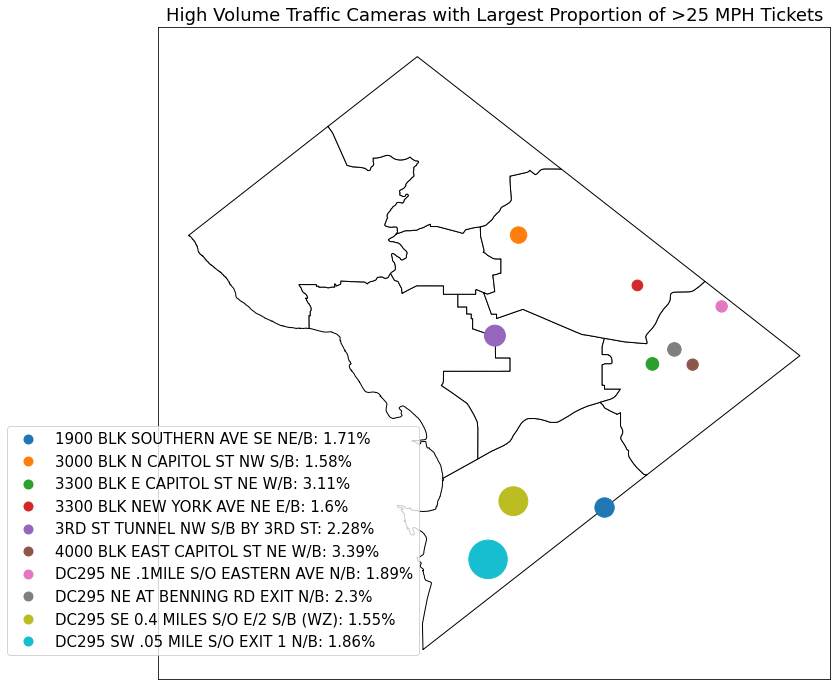

In [103]:
#Plot locations of high traffic cameras with the greatest proportion of >25 MPH Tickets 
ax=DC.plot(color='white',edgecolor='black',figsize=(20, 12))
gdf_a.plot(ax=ax, column='String',categorical=True,legend=True,markersize=gdf_a['Total_Tickets_Location']/100)
plt.title('High Volume Traffic Cameras with Largest Proportion of >25 MPH Tickets')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.2, 0.2, 0.2))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [104]:
speed_query2=df_all_merged.copy()
speed_dict={'OVER 25 MPH IN EXCESS OF LIMIT ON NON-CONTROLLED A':'SPEED > 20 MPH OVER THE SPEED LIMIT',
 'OVER 25 MPH IN EXCESS OF LIMIT ON CONTROLLED ACCES':'SPEED > 20 MPH OVER THE SPEED LIMIT',
'SPEED 26-30 MPH OVER THE SPEED LIMIT':'SPEED > 20 MPH OVER THE SPEED LIMIT',
'SPEED 16-20 MPH OVER THE SPEED LIMIT':'SPEED 16-20 MPH OVER THE SPEED LIMIT',
'SPEED 11-15 MPH OVER THE SPEED LIMIT':'SPEED 11-15 MPH OVER THE SPEED LIMIT',
'SPEED 21-25 MPH OVER THE SPEED LIMIT':'SPEED > 20 MPH OVER THE SPEED LIMIT'}
speed_query2.violation_process_desc=speed_query2.violation_process_desc.map(speed_dict)
speed_query2=speed_query2[speed_query2.CAMERA_TYPE=='SPEED'].groupby(['ADDRESS','violation_process_desc']).num_tickets.sum().reset_index()
speed_query2=pd.merge(speed_query2,df_cameras_2[['X','Y','ADDRESS']],how='left',left_on='ADDRESS',right_on='ADDRESS')


speed_query2['Proportion']=speed_query2.groupby(['ADDRESS']).num_tickets.transform(proportion)
speed_query2['Total_Tickets_Location']=speed_query2.groupby(['ADDRESS']).num_tickets.transform(total_tick)

In [105]:
#Manually Add Missing Cordinates For Cameras
speed_query2.loc[speed_query2.ADDRESS=='3300 BLK E CAPITOL ST NE W/B','Y']=38.890090
speed_query2.loc[speed_query2.ADDRESS=='3300 BLK E CAPITOL ST NE W/B','X']=-76.959960

speed_query2.loc[speed_query2.ADDRESS=='DC 295 .4MI S/O PA AVE SE SW/B (WZ)','Y']=38.872214
speed_query2.loc[speed_query2.ADDRESS=='DC 295 .4MI S/O PA AVE SE SW/B (WZ)','X']=-76.981231

speed_query2.loc[speed_query2.ADDRESS=='I395 SW 250 FEET AFTER EXIT 4 E/B','Y']=38.881401
speed_query2.loc[speed_query2.ADDRESS=='I395 SW 250 FEET AFTER EXIT 4 E/B','X']=-77.024190

In [106]:
#Select Locations with over 10000 Violations,and select >30 mph violations
cond_a=speed_query2.Total_Tickets_Location>10000
cond_b=speed_query2.violation_process_desc=='SPEED > 20 MPH OVER THE SPEED LIMIT'
speed_query_2a=speed_query2[(cond_a)&(cond_b)].sort_values('Proportion',ascending=False)[0:10]

In [107]:
speed_query_2a['String']=speed_query_2a.ADDRESS+': '+speed_query_2a.Proportion.astype('str')+'%'

In [108]:
#Make geopandas dataframe out of speed camera data
gdf_b = gpd.GeoDataFrame(speed_query_2a, geometry=gpd.points_from_xy(speed_query_2a.X, speed_query_2a.Y))
gdf_b.head(10)

,ADDRESS,violation_process_desc,num_tickets,X,Y,Proportion,Total_Tickets_Location,String,geometry
149,3300 BLK E CAPITOL ST NE W/B,SPEED > 20 MPH OVER THE SPEED LIMIT,1370,-76.959960,38.890090,8.55,16021,3300 BLK E CAPITOL ST NE W/B: 8.55%,POINT (-76.95996 38.89009)
200,4000 BLK EAST CAPITOL ST NE W/B,SPEED > 20 MPH OVER THE SPEED LIMIT,1064,-76.946099,38.889843,8.38,12700,4000 BLK EAST CAPITOL ST NE W/B: 8.38%,POINT (-76.94610 38.88984)
365,SUITLAND PK W/B @ STANTON RD SE,SPEED > 20 MPH OVER THE SPEED LIMIT,3589,-76.983305,38.853305,7.71,46553,SUITLAND PK W/B @ STANTON RD SE: 7.71%,POINT (-76.98330 38.85331)
308,DC295 SW .05 MILE S/O EXIT 1 N/B,SPEED > 20 MPH OVER THE SPEED LIMIT,11353,-77.016595,38.822754,7.69,147628,DC295 SW .05 MILE S/O EXIT 1 N/B: 7.69%,POINT (-77.01659 38.82275)
293,DC 295 .4MI S/O PA AVE SE SW/B (WZ),SPEED > 20 MPH OVER THE SPEED LIMIT,6529,-76.981231,38.872214,6.88,94890,DC 295 .4MI S/O PA AVE SE SW/B (WZ): 6.88%,POINT (-76.98123 38.87221)
305,DC295 SE 0.4 MILES S/O E/2 S/B (WZ),SPEED > 20 MPH OVER THE SPEED LIMIT,5382,-77.007876,38.842801,6.47,83163,DC295 SE 0.4 MILES S/O E/2 S/B (WZ): 6.47%,POINT (-77.00788 38.84280)
191,3RD ST TUNNEL NW S/B BY 3RD ST,SPEED > 20 MPH OVER THE SPEED LIMIT,2826,-77.014228,38.899839,6.46,43762,3RD ST TUNNEL NW S/B BY 3RD ST: 6.46%,POINT (-77.01423 38.89984)
302,DC295 NE AT BENNING RD EXIT N/B,SPEED > 20 MPH OVER THE SPEED LIMIT,1135,-76.952387,38.895083,6.20,18300,DC295 NE AT BENNING RD EXIT N/B: 6.2%,POINT (-76.95239 38.89508)
254,600 BLK KENILWORTH AVE NE S/B,SPEED > 20 MPH OVER THE SPEED LIMIT,13417,-76.948370,38.898948,6.19,216797,600 BLK KENILWORTH AVE NE S/B: 6.19%,POINT (-76.94837 38.89895)
323,I395 SW 250 FEET AFTER EXIT 4 E/B,SPEED > 20 MPH OVER THE SPEED LIMIT,1873,-77.024190,38.881401,6.02,31115,I395 SW 250 FEET AFTER EXIT 4 E/B: 6.02%,POINT (-77.02419 38.88140)


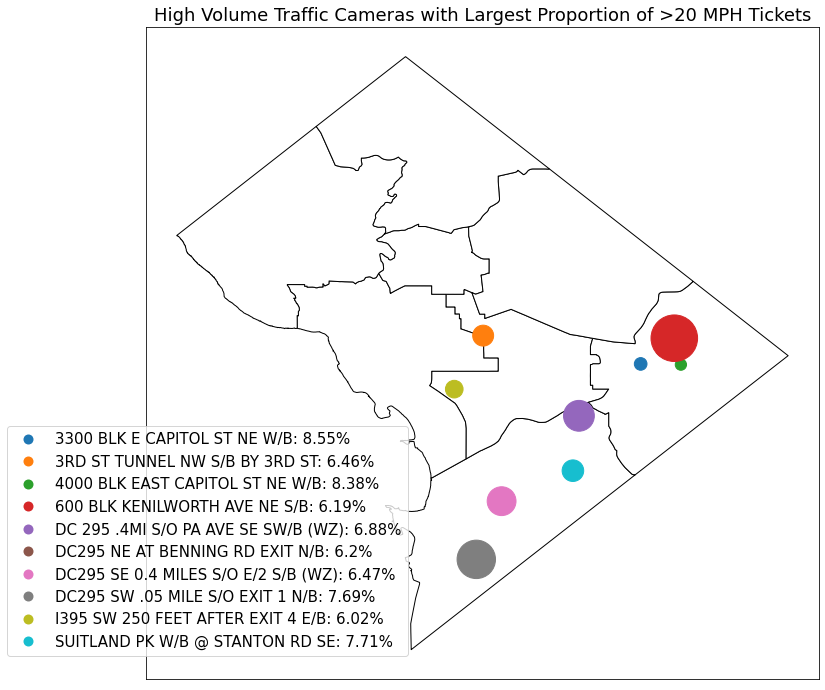

In [109]:
#Plot locations of high traffic cameras with the greatest proportion of >20 MPH Tickets 
ax=DC.plot(color='white',edgecolor='black',figsize=(20, 12))
gdf_b.plot(ax=ax, column='String',categorical=True,legend=True,markersize=gdf_b['Total_Tickets_Location']/100)
plt.title('High Volume Traffic Cameras with Largest Proportion of >20 MPH Tickets')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.2, 0.2, 0.2))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [111]:
#Code for spliting up border ward, which comes from automated camera locations data

#Group Automated Tickets by Ward
#ward_auto_counts=pd.DataFrame(df_all_merged[df_all_merged.CAMERA_TYPE!='NOT CAMERA ENFORCED'].groupby('WARD')['num_tickets'].sum()).reset_index()
#ward_auto_counts

#Create new data frame with border ward tickets split between two wards
#border_tickets=pd.DataFrame({'Ward':[i for i in range(1,9)]})
#border_tickets['count']=0
#border_wards=[]
#for i in range(len(ward_auto_counts)):
#    if len(ward_auto_counts.loc[i,'WARD'])>1:
#        num=int(ward_auto_counts.loc[i,'num_tickets'])/2
#        ward_a=ward_auto_counts.loc[i,'WARD'][0]
#        ward_b=ward_auto_counts.loc[i,'WARD'][2]
#        border_tickets.loc[int(ward_a)-1,'count']=border_tickets.loc[int(ward_a)-1,'count']+num
#        border_tickets.loc[int(ward_b)-1,'count']=border_tickets.loc[int(ward_b)-1,'count']+num
#       border_wards.append(ward_auto_counts.loc[i,'WARD'])

#Remove border wards from main data Frame
#ward_auto_counts=ward_auto_counts[~ward_auto_counts.WARD.isin(border_wards)]

#Add border tickets to main count
#border_tickets = border_tickets.astype({"Ward": str, "count": int})
#ward_auto_counts=pd.merge(ward_auto_counts,border_tickets,left_on='WARD',right_on='Ward')

#Get total tickets by ward 
#ward_auto_counts['num_tickets']=ward_auto_counts['num_tickets']+ward_auto_counts['count']
#ward_auto_counts.drop(columns=['Ward','count'],inplace=True)

#Change Ward Type to int
#ward_auto_counts = ward_auto_counts.astype({"WARD": int, "num_tickets": int})